In [22]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

class ERA5_With_Observations(Dataset):
    def __init__(self, csv_file, label_columns, date_column, lat_column, lon_column, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with data.
            label_columns (list of strings): List of column names for the labels/targets.
            date_column (string): The column name for the date.
            lat_column (string): The column name for latitude.
            lon_column (string): The column name for longitude.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = pd.read_csv(csv_file)
        self.label_columns = label_columns  # Multiple label columns
        self.date_column = date_column
        self.lat_column = lat_column
        self.lon_column = lon_column
        self.transform = transform
        
        # Convert the date column to datetime and then to a timestamp (e.g., seconds since epoch)
        self.data[self.date_column] = pd.to_datetime(self.data[self.date_column], errors='coerce')
        self.data['date_timestamp'] = self.data[self.date_column].astype(int) / 10**9  # Convert to seconds since epoch
        
        # Group data by date and merge latitudes and longitudes as arrays
        self.date_groups = self.data.groupby('date_timestamp').agg({
            'latitude': list,
            'longitude': list,
            **{label: list for label in self.label_columns}  # Keep all label values as arrays
        }).reset_index()

    def __len__(self):
        return len(self.date_groups)

    def __getitem__(self, idx):
        # Extract the grouped row by index
        row = self.date_groups.iloc[idx]
        
        # Extract the date, latitude and longitude arrays, and labels arrays
        date = row['date_timestamp']
        latitude = np.array(row['latitude'])
        longitude = np.array(row['longitude'])
        
        # Convert lat/long arrays to a 2D array (if desired)
        location = np.column_stack((latitude, longitude))
        
        # Extract label arrays
        labels = {label: torch.tensor(row[label], dtype=torch.float32) for label in self.label_columns}
        
        # Combine into a sample dictionary
        sample = {
            'date': torch.tensor(date, dtype=torch.float32),
            'location': torch.tensor(location, dtype=torch.float32),  # Array of lat/long pairs
            'labels': labels  # Labels as arrays
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def coarsen_data(df, coarsen_factor=2):
    """
    Coarsen the DataFrame's latitude and longitude into bins of the specified coarsen factor.

    Parameters:
    - df: pandas DataFrame containing 'longitude', 'latitude' columns.
    - coarsen_factor: int, the factor by which to coarsen the grid (default is 5 for 5°x5° bins).

    Returns:
    - DataFrame with binned latitude and longitude.
    """
    # Define bins for latitude and longitude
    long_bins = np.arange(-20, 55, coarsen_factor)
    lat_bins = np.arange(-40, 40, coarsen_factor)
    
    # Bin the latitude and longitude columns
    df['longitude_bin'] = pd.cut(df['longitude'], bins=long_bins, include_lowest=True)
    df['latitude_bin'] = pd.cut(df['latitude'], bins=lat_bins, include_lowest=True)
    
    return df, long_bins, lat_bins

def plot_1_variable_from_item(item, variable):
    """
    Plot a specific timestep from an item of the Dataset, with latitude and longitude representing top-right corners of 5°x5° grid cells.
    
    Parameters:
    - item: A dictionary containing 'date', 'latitude', 'longitude', and the variable to plot.
    - variable: str, the variable name to plot.
    """
    # Coarsen the data
    latitude = item['location'][:, 0]  # Latitudes
    longitude = item['location'][:, 1]  # Longitudes

    # Create a DataFrame with latitude, longitude, and variable data
    data = {
        'latitude': latitude,
        'longitude': longitude,
        variable: item['labels'][variable]  # Assuming item['labels'] is a dict with variables
    }
    df = pd.DataFrame(data)
    
    # Coarsen the data
    df, long_bins, lat_bins = coarsen_data(df)
    
    # Extract the date from the item
    time = pd.to_datetime(item['date'], unit='s')  # Convert to datetime (if it's a timestamp)
    
    # Filter DataFrame for the specified time (though there's only one row here)
    df_filtered = df

    if df_filtered.empty:
        print(f"No data available for {time}.")
        return

    # Pivot table to create a grid for plotting
    grid = df_filtered.pivot_table(
        index='latitude_bin', columns='longitude_bin', values=variable, fill_value=np.nan
    )

    # Extract the bin boundaries from the intervals
    lon_bins = [interval.mid for interval in grid.columns]
    lat_bins = [interval.mid for interval in grid.index]
    values_grid = grid.values

    # Create plot
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={"projection": ccrs.PlateCarree()})
    ax.coastlines(resolution="10m")

    # Create meshgrid for plotting
    lon_grid, lat_grid = np.meshgrid(lon_bins, lat_bins)

    mesh = ax.pcolormesh(
        lon_grid, lat_grid, values_grid,
        cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree(), shading='auto'
    )
    
    ax.set_extent([-20, 55, -40, 40], crs=ccrs.PlateCarree())

    plt.colorbar(mesh, ax=ax, shrink=0.6, label=variable)
    formatted_time = time.strftime("%B %d, %Y at %I:%M %p")
    plt.title(f"ERA5 - Africa {variable} on {formatted_time}")
    plt.show()

In [24]:

# Define file path and columns
csv_file = 'dataset.csv'  # Replace with your file path
label_columns = ['not_recieved', 'low_availability',
       'high_availability', 'complete', 'STL1_GDS0_DBLY', '2T_GDS0_SFC',
       '2D_GDS0_SFC', 'STL2_GDS0_DBLY', 'STL3_GDS0_DBLY', 'SKT_GDS0_SFC',
       'STL4_GDS0_DBLY', 'population']
date_column = 'date'  # The column with dates
lat_column = 'latitude'  # The column with latitude
lon_column = 'longitude'  # The column with longitude

# Create Dataset from CSV
dataset = ERA5_With_Observations(csv_file=csv_file, 
                                label_columns=label_columns, 
                                date_column=date_column,
                                lat_column=lat_column,
                                lon_column=lon_column)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [27]:
# Extract the first item
item = dataset[0]

item

{'date': tensor(1.5463e+09),
 'location': tensor([[-38., -18.],
         [-38., -16.],
         [-38., -14.],
         ...,
         [ 38.,  50.],
         [ 38.,  52.],
         [ 38.,  54.]]),
 'labels': {'not_recieved': tensor([0., 0., 0.,  ..., 3., 3., 3.]),
  'low_availability': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'high_availability': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'complete': tensor([0., 0., 0.,  ..., 9., 9., 9.]),
  'STL1_GDS0_DBLY': tensor([     nan,      nan,      nan,  ..., 276.1655, 281.5841, 281.8651]),
  '2T_GDS0_SFC': tensor([     nan,      nan,      nan,  ..., 275.2467, 279.5721, 281.9026]),
  '2D_GDS0_SFC': tensor([     nan,      nan,      nan,  ..., 271.5715, 276.2800, 278.1574]),
  'STL2_GDS0_DBLY': tensor([     nan,      nan,      nan,  ..., 277.1924, 281.9625, 282.1367]),
  'STL3_GDS0_DBLY': tensor([     nan,      nan,      nan,  ..., 280.3858, 283.1761, 283.7369]),
  'SKT_GDS0_SFC': tensor([     nan,      nan,      nan,  ..., 273.8087, 278.0401, 28

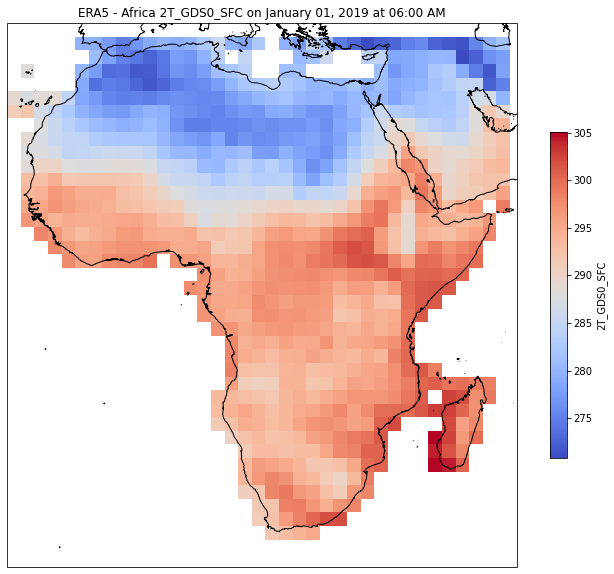

In [30]:
plot_1_variable_from_item(item, '2T_GDS0_SFC')

In [ ]:
plot_1_variable_from_item(item, 'not_recieved')